<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Заключение</a></span></li></ul></div>

# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет *«Хлеб-Соль»* внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Нам нужно построить модель, которая по фотографии определит приблизительный возраст человека. При этом значение MAE не должно превышать 8 чтобы модель считалась подходящей.

## Исследовательский анализ данных

Загрузка библиотек и настройки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError

sns.set(rc={'figure.figsize':(10,6)})

Загрузка данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        batch_size=32,
        class_mode='raw',
        seed=42) 

Found 7591 validated image filenames.


In [23]:
display(labels.head())
print('_'*38)
labels.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


______________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [12]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Построим график распределения возраста

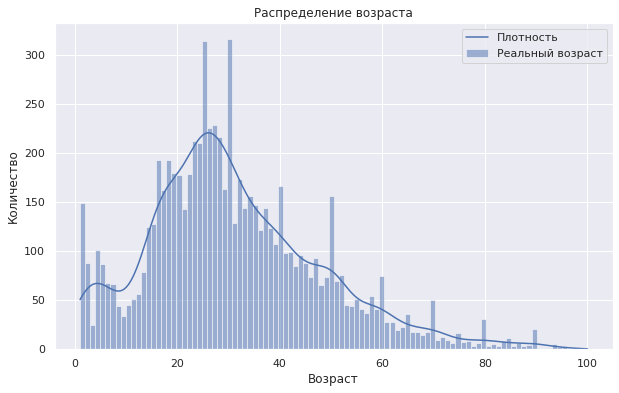

In [10]:
sns.histplot(labels,bins=100,kde=True)

plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста')
plt.legend(['Плотность','Реальный возраст']);

И выведем на экран несколько изображений

In [12]:
features, target = next(train_gen_flow)

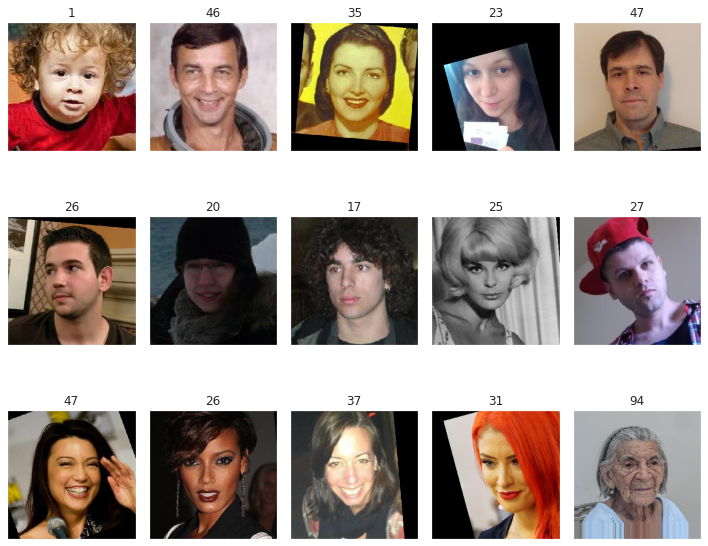

In [13]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_title(target[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Summary

- В нашем распоряжении 7591 фото людей
- Данные размечены, т.е. к каждому фото указан возраст, который и станет целью предсказания нашей модели
- На первый взгляд данные могут содержать некоторые аугментации (смещение, поворот)
- Распределение возраста близко к нормальному, с довольно большим правым хвостом и пиками в районе 1, 25 и далее возрастах кратных 10. Последнее может говорить о том, что часть данных могла быть размечена не по точному возрасту а по возрастной группе
- Общий вид графика может предупредить нас о том, что
    1. итоговая модель может давать заниженные результаты при возрасте, большем 60 и в промежутке от 1 до, примерно, 15 лет.
    2. модель может давать смещенные в сторону 30 лет результаты из-за большего количества людей именно около этого возраста

## Обучение модели

Ниже код, который использовался для обучения и валидации модели на сервере.

Потоковая загрузка тренировочной и валидационной/тестовой выборок
   - в загрузку тренировочной выборки также было добавлено создание аугментаций (отражения, повороты до 90 гразусов и смещения до 20%)
    
Создание сверточной нейронной сети на основе предобученной ResNet50 (с весами imagenet) и добавлением 3х полносвязных слоев

Обучение и валидация

```python

def load_train(path):
    
    train_datagen = ImageDataGenerator(
        validation_split = .2,
        rescale = 1./255, 
        horizontal_flip = True, 
        rotation_range = 45,
        width_shift_range=.2,
        height_shift_range=.2)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'training',
        seed=42)
    
    return train_gen_flow


def load_test(path):
    
    test_datagen = ImageDataGenerator(
        validation_split = 0.25, 
        rescale = 1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'validation',
        seed=12345)
    
    
    return test_gen_flow


def create_model(input_shape = (224, 224, 3)):

    backbone = ResNet50(
        input_shape = input_shape, 
        weights='imagenet', 
        include_top=False
    )
        
    model = Sequential()
    optimizer = Adam(lr = 0.0001)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model


def train_model(
        model, 
        train_data, 
        test_data, 
        batch_size=None, 
        epochs=15,
        steps_per_epoch=None, 
        validation_steps=None
):

    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps, verbose = 2)
    
    return model

```

```
Found 6073 validated image filenames.
Found 1897 validated image filenames.

Train for 190 steps, validate for 60 steps
Epoch 1/15
2022-10-25 11:38:29.912714: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-25 11:38:30.493218: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
Epoch 2/15
190/190 - 112s - loss: 251.7657 - mae: 11.7838 - val_loss: 319.3802 - val_mae: 13.2746
190/190 - 105s - loss: 136.8297 - mae: 8.9164 - val_loss: 360.5904 - val_mae: 14.1599
Epoch 3/15
190/190 - 104s - loss: 118.1587 - mae: 8.2649 - val_loss: 245.2477 - val_mae: 11.7891
Epoch 4/15
190/190 - 100s - loss: 109.5246 - mae: 7.9388 - val_loss: 155.0223 - val_mae: 9.3487
Epoch 5/15
190/190 - 102s - loss: 94.1644 - mae: 7.4014 - val_loss: 123.7904 - val_mae: 8.2420
Epoch 6/15
190/190 - 97s - loss: 91.2228 - mae: 7.3180 - val_loss: 116.3828 - val_mae: 7.9590
Epoch 7/15
190/190 - 95s - loss: 81.5993 - mae: 6.9249 - val_loss: 136.6246 - val_mae: 9.5569
Epoch 8/15
190/190 - 96s - loss: 75.4765 - mae: 6.6622 - val_loss: 112.4283 - val_mae: 8.3652
Epoch 9/15
190/190 - 95s - loss: 72.2777 - mae: 6.5027 - val_loss: 128.5622 - val_mae: 8.2193
Epoch 10/15
190/190 - 95s - loss: 64.5138 - mae: 6.1309 - val_loss: 130.3072 - val_mae: 8.7634
Epoch 11/15
190/190 - 98s - loss: 59.2783 - mae: 5.9524 - val_loss: 94.4731 - val_mae: 7.3263
Epoch 12/15
190/190 - 98s - loss: 58.8503 - mae: 5.9051 - val_loss: 125.5918 - val_mae: 8.6879
Epoch 13/15
190/190 - 97s - loss: 57.3356 - mae: 5.7989 - val_loss: 104.3519 - val_mae: 7.5565
Epoch 14/15
190/190 - 98s - loss: 50.1418 - mae: 5.4221 - val_loss: 114.6856 - val_mae: 8.1067
Epoch 15/15
190/190 - 98s - loss: 50.4430 - mae: 5.4393 - val_loss: 101.9585 - val_mae: 7.3487
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 101.9585 - mae: 7.3487
Test MAE: 7.3487

```

## Заключение

Целью данного проекта было разработать нейронную сеть, которая предсказывает возраст человека на фотографии с абсолютным отклонением(MAE) от реального не более 8 лет

В нашем распоряжении было 7.5k размеченных фотографий. Распределение возраста близко к нормальному, большинство людей на фото в возрасте около 30. Это могло повлиять на предсказания модели для людей существенно старше или младше

Для улучшения качества модели в тренировочные данные были добавлены **аугментации**:
- горизотальное и вертикальное **отражения**
- **поворот** фото на угол до 90 градусов
- вертикальное и горизонтальное **смещение** до 20% от размера фото

Итоговая модель основана на предобущенной сверточной сети **ResNet-50** с весами ***imagenet*** и добавлением 3 полносвязных слоев

После 15 эпох обучения модель показала **MAE** в **7,3487**, что меньше 8 и удовлетворяет условиям поставленной задачи. Также это значит, что предсказания обученной модели отличаются от реального возраста людей на фото менее чем на 8 лет

Полученная модель позволит рекомендовать товары для покупки исходя из возраста посетителя

Для контроля продажи алкоголя модель подойдет в меньшей степени. Из-за большого количества фото около 30 лет модель может давать смещенные "вверх" оценки при реальном возрасте меньше 30